## Tree-based Methods: Decision Trees

The basic idea behind Tree-based methods is to partition the feature-space into a set of non-overlapping rectangular regions, and fit a simple model (often just a constant) in each region. To ensure simple (rectangular) regions, and for other reasons like interpretability, the splitting is done using ___recursive binary splitting___. We first split the feature space into two regions, and model the response as simply the mean of all observations $Y$ in the region. We choose the variable and the split-point to define the cut point, to achieve the best fit. Then the process is repeated, by splitting one of the regions into 2 again, by choosing another variable and split-point greedily to achieve best fit.

Let's consider an example below where we regress $\log Salary$ on $Years$ and $Hits$ using Decision Trees.

In [1]:
import numpy
import pandas

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn import tree
import pydot

     Hits  Years    Salary  logSalary
217     1      2  2127.333   7.662624
216    60      3   137.000   4.919981
186    85      7   300.000   5.703782
163   200     13  2412.500   7.788419
179   171     13  1800.000   7.495542


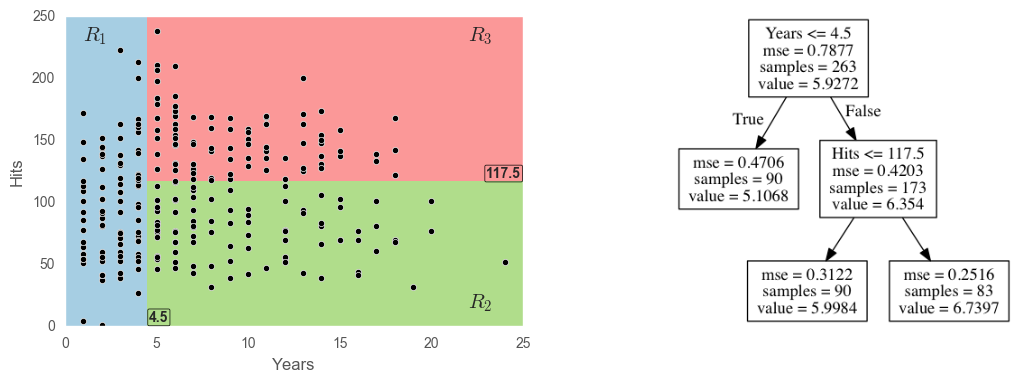

In [2]:
hitters = pandas.read_csv('../data/islr_data/Hitters.csv', usecols=['Years', 'Hits', 'Salary'])
hitters.dropna(inplace=True)
hitters['logSalary'] = numpy.log(hitters['Salary'])

X = hitters[['Years', 'Hits']].values
y = hitters['logSalary'].values

regr = tree.DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

xx, yy = numpy.meshgrid(numpy.arange(0, 25, 0.02),
                        numpy.arange(0, 250, 1))
Z = regr.predict(numpy.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

colors = sns.color_palette('Paired', 6)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
ax = axes[0]
ax.pcolormesh(xx, yy, Z, cmap=ListedColormap(colors[::2]))
ax.scatter(hitters['Years'], hitters['Hits'], c='k')
ax.set_xlim(0, 25)
ax.set_ylim(0, 250)
ax.set_xlabel('Years')
ax.set_ylabel('Hits')
ax.text(4.6, 4, '4.5', fontweight='bold', bbox=dict(boxstyle='round, pad=.1', facecolor='none', edgecolor='black'))
ax.text(23, 120, '117.5', fontweight='bold', bbox=dict(boxstyle='round, pad=.1', facecolor='none', edgecolor='black'))
ax.text(1, 230, r'$R_1$', size=15)
ax.text(22, 15, r'$R_2$', size=15)
ax.text(22, 230, r'$R_3$', size=15)


tree.export_graphviz(regr, out_file='tree.dot', feature_names=['Years', 'Hits'])
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

axes[1].imshow(plt.imread('tree.png'))
axes[1].grid('off')
axes[1].set_xticks([])
axes[1].set_yticks([])

print(hitters.sample(5))

The plot above shows that there are 3 regions generated by splitting the feature space: $R_1 = \{X \mid Years \le 4.5\}$, $R_2 = \{X \mid Years > 4.5, Hits < 117.5\}$ and $R_3 = \{X \mid Years > 4.5, Hits \ge 117.5\}$. The image on the right shows the tree structure generated. The predicted value for a test observation is simply the mean of all observations in the region that the test observation lies in. 

A key advantage of recursive binary tree is the interpretability. $Years$ seems to be the most important factor in determining $Salary$: for $Years \le 4.5$, the predicted value for $log Salary$ is 5.107, which results in a salary of $\$165141$. Given that the player has less experience ($Years \le 4.5$), his number of hits don't seem to impact his salary. For players with $Years > 4.5$, the number of hits affect the salary: for players in region $R_2$ with $Hits \le 117.5$, we predict a salary of $e^{5.9984} = \$402783$ and for region $R_3$ with $Hits > 117.5$, we predict a salary of $e^{6.7397} = \$845307$.

### Regression Trees
Our data consists of $n$ observations $(x_i, y_i)$ for $i = 1, 2 ... n$ with $p$ predictors, where $x_i = (x_{i1}, x_{i2}, ..., x_{ip})$. The goal is to now partition the feature-space into rectangular regions $R_1, R_2 ... R_M$, and we model the response as a constant $c_m$ in each region:

$$f(x) = \sum_{m=1}^M c_m I(x \in R_m)$$

We could adopt minimization of RSS as our criterion:

$$\sum_{m=1}^M \sum_{i \in R_m} (y_i - \hat f(x_i))^2$$

Best $c_m$ is just the average of $y_i$ in the region $R_m$:
$$\hat c_m = ave(y_i \mid x_i \in R_m)$$

Finding the best binary partition is generally computationally infeasible, and so we adopt a greedy stratedy known as ___recursive binary splitting___. Consider a splitting variable $j$ and split point $s$, using which we can split the feature-space into two half-planes defined by:

\begin{align}
R_1(j, s) &= \{X \mid X_j \le s\} \\
R_2(j, s) &= \{X \mid X_j > s\}
\end{align}

We seek to find $j$ and $s$ such that we minimize:

$$\sum_{i: x_i \in R_1(j,s)} (y_i - \hat c_1)^2 + \sum_{i: x_i \in R_2(j,s)} (y_i - \hat c_2)^2 $$

where $\hat c_1$ and $\hat c_2$ are as defined above for regions $R_1$ and $R_2$. Having obtained 2 regions, we again split one of the regions such that we minimize the RSS, and obtain 3 regions. The process continues on all the regions till some stopping criterion is satisfied. How large should we grow a tree? A very large tree might overfit the data, while a small tree might not learn all the dynamics. We could think of several strategies, but the preferred strategy is to grow a large tree $T_0$ and then prune it back using some criterion to obtain a subtree.

#### Cost-Complexity Pruning
We can define a subtree $T \subset T_0$, that can be obtained by pruning $T_0$, i.e., collapsing any number of non-terminal nodes. Terminal nodes are indexed by $m$, with node $m$ representing region $m$; $\lvert T \rvert$ is the number of terminal nodes in $T$. Let the number of observations in $m$th region be $n_m = \# \{x_i \in R_m\}$. We can define the cost-complexity criterion as:

$$C_\alpha(T) = \sum_{m=1}^{\lvert T \rvert} \sum_{x_i \in R_m} (y_i - \hat c_m)^2 + \alpha \lvert T \rvert$$

where $\alpha$ is the penalty term and we penalize for the number of terminal nodes. The idea is to find, for each $\alpha$, the subtree $T_\alpha \subseteq T_0$ that minimizes $C_\alpha(T)$. When $\alpha = 0$, the solution is the full tree $T_0$, and increasing $\alpha$ results in smaller trees $T_\alpha$. It can be shown that, for each $\alpha$ there exists a unique smallest subtree $T_\alpha$ that minimizes $C_\alpha(T)$. Rather than going through every possible subtree to find $T_\alpha$, it can be shown that $T_\alpha$ is generated as a part of the sequence when a technique called ___weakest link pruning___ is used. In weakest link pruning, we successively collapse the non-terminal node that produces the smallest per-node increase in $\sum_m \sum_{x_i \in R_m} (y_i - \hat c_m)^2$, till we reach the root (single-node) tree. This sequence will contain $T_\alpha$ that minimizes $C_\alpha(T)$. We can find a set of $\{T_\alpha\}$ for different $\alpha$, and can finally choose $\hat \alpha$ and the corresponding minimal subtree $T_\hat \alpha$ by cross-validation, which will be our final tree.


### Classification Trees
The only change needed in the tree algorithm to adapt to qualitative responses is the criteria for splitting nodes and pruning the tree. We used the RSS as criterion (or impurity measure) in Regression trees, which will not be suitable here. Also, instead of predicting the mean of the observations as in the case of Regression trees, here we predict that each observation belongs to the most commonly occurring class. In a node $m$, representing region $R_m$ with $n_m$ observations, the proportion of class $k$ observations in node $m$ is given by

$$\hat p_{mk} = \frac1{n_m} \sum_{x_i \in R_m} I(y_i = k)$$

We classify the observation in node $m$ to the class $k(m) = \arg\max_k \hat p_{mk}$, the majority class in node $m$. Measures for node impurity (instead of RSS in regression trees) for classification trees include:

- ___misclassification error rate___: fraction of observation in the training class that do not belong to the most commonly occurring class.

$$E = 1 - \max_k \hat p_{mk}$$

- ___gini index___: a measure of total variance across the $K$ classes

\begin{align}
G &= \sum_{k \ne k^\prime} \hat p_{mk} \hat p_{mk^\prime}\\
&= \sum_{k=1}^K \hat p_{mk} (1 - \hat p_{mk})
\end{align}

- ___cross-entropy___: 

$$D = - \sum_{k=1}^K \hat p_{mk} \log \hat p_{mk}$$

If all $\hat p_{mk}$'s are close to $0$ or $1$, gini index and cross-entropy will take a small value. A small value indicates that the node contains predominantly observations from a single class, and hence pure. The gini index and cross-enropy are more sensitive to changes in the node probabilities than the misclassification error. In the case of a 2 splits having similar misclassification error rate, the split that results in a purer node is preferred. In such cases of pure nodes, the gini index and cross-entropy have a lower value, and are hence considered more sensitive to node purity. For this reason, gini index or cross-entropy is often used while growing the tree, and the misclassification error while pruning. Another advantage with gini index and cross-entropy is that they are differentiable and hence of advantage in numerical optimizations.

Trees have high variance and are often instable. This is because of their hierarchical nature: the effect of some error in the top split is propagated down. Although quite useful in certain situations, trees lack smoothness and hence not very useful for all regression settings. Trees however become incredibly powerful when several trees are aggregated together, like random forest, boosting, bagging etc.